In [1]:
%pylab inline

import glob
from itertools import product as iter_prod
import pickle
from time import time
from typing import Callable, Dict, Type

import pandas as pd
from scipy.stats import norm as sp_norm
import seaborn as sns

sns.set(style='ticks', context='talk')

Populating the interactive namespace from numpy and matplotlib


# Part 1

## Assignment 1

In [2]:
class SupervisedMethod:
    def __init__(self, *args, **kwargs) -> 'SupervisedMethod':
        self._cvloss = None

    def fit(self, X: np.ndarray, y: np.ndarray) -> 'SupervisedMethod':
        raise NotImplementedError()

    def predict(X: np.ndarray) -> np.ndarray:
        raise NotImplementedError()

    @property
    def cvloss(self):
        return self._cvloss

    @cvloss.setter
    def cvloss(self, val):
        self._cvloss = val


def params_prod(params):
    return (dict(zip(params, x))
            for x in iter_prod(*params.values()))


def zero_one_loss(y_true: np.ndarray,
                  y_pred: np.ndarray) -> float:
    y_true: np.ndarray = y_true == 1
    y_pred: np.ndarray = y_pred >= 0
    return (y_true == y_pred).mean()


def cv(X: np.ndarray,
       y: np.ndarray,
       method: Type[SupervisedMethod],
       parameters: Dict,
       nfolds: int=10,
       nrepetitions: int=5,
       loss_function: Callable[[np.ndarray, np.ndarray],
                               float]=zero_one_loss,
       state: np.random.RandomState=None)\
        -> SupervisedMethod:
    assert len(X) == len(y)
    N, M = X.shape
    fold_size = int(np.ceil(N/nfolds))
    if state is not None:
        np.random.set_state(state)
    
    best_params = None
    best_loss = np.inf
    avg_param_time = 0
    init_param_time = time()
    param_prod_size = np.product([len(p) for p in parameters.values()])
    for i, params in enumerate(params_prod(parameters)):
        print(f"Parameter iteration nr: {i+1}.")
        print(f"Params: {params}")

        loss = 0
        avg_rep_time = 0
        init_rep_time = time()
        for j in range(nrepetitions):
            indexes = np.random.choice(np.arange(N, dtype=int),
                                       size=N, replace=False)
            folds = [indexes[j: j+fold_size]
                     for i in range(0, N, fold_size)]
            avg_fold_time = 0
            init_fold_time = time()
            for k, fold in enumerate(folds):
                idx_train = [fold for l, fold in enumerate(folds)
                             if l != k]
                idx_train = np.r_[idx_train].flatten()
                X_train = X[idx_train]
                y_train = y[idx_train]
                X_val = X[fold]
                y_val = y[fold]
                model = method(**params)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_val)
                loss += loss_function(y_val, y_pred)
        loss /= nfolds * nrepetitions
        if loss < best_loss:
            best_loss = loss
            best_params = params
        elapsed_param_time = time() - init_param_time
        avg_param_time = (avg_param_time*i + elapsed_param_time)/(i+1)
        print(f"Loss: {loss}")
        print(f"Elapsed: {elapsed_param_time: 0.4f}s. "
              f"Time to finish: {avg_param_time*(param_prod_size-i):0.4f}s")
        print(f"Best parameters: {best_params}")
        print(f"Best loss: {best_loss}")
        print()

    model = method(**best_params)
    model.cvloss = best_loss
    model.fit(X, y)
    
    return model

## Assignment 2

In [3]:
def linear(x, z, _):
    return np.inner(x, z)


def polynomial(x, z, p):
    return (np.inner(x, z) + 1)**p


def gaussian(x, z, w):
    x_sq = (x**2).sum(axis=1, keepdims=True)
    xz = x @ z.T
    z_sq = (z**2).sum(axis=1)
    dist = x_sq - 2*xz + z_sq
    return np.exp(-dist/(2 * w**2))


def krr_loo_cv(X, y, kernels, kp_range):
    N, *_ = X.shape
    best_kp = best_c = best_err = np.inf
    best_kernel = None
    for kernel, kp in iter_prod(kernels, kp_range):
        K = kernel(X, X, kp)
        L, U = np.linalg.eig(K)
        L = L.real
        c_center = L.mean()
        c_range = c_center * np.logspace(-5, 5, 11)

        UL = U @ np.diag(L)
        for c in c_range:
            Lc = 1/(L + c)
            S = UL @ np.diag(Lc) @ U.T
            denominator = (1 - np.diag(S))**2
            numerator = (y - S@y)**2
            err = (numerator/denominator).mean()
            if err < best_err:
                best_err = err
                best_kernel = kernel
                best_kp = kp
                best_c = c

    return best_kernel, best_kp, best_c, best_err


class krr(SupervisedMethod):
    def __init__(self, kernel, kernelparameter, regularization=0):
        super().__init__()
        if isinstance(kernel, str):
            kernel = globals()[kernel]
        self.kernel = kernel
        self.kernelparameter = kernelparameter
        self.regularization = regularization
        self.alpha = None

    def fit(self, X: np.ndarray, y: np.ndarray) -> 'krr':
        N, *_ = X.shape
        kp = self.kernelparameter
        kernel = self.kernel
        if self.regularization == 0:
            _, _, C, best_err = krr_loo_cv(X, y, [kernel], [kp])
            self.cvloss = best_err
            self.regularization = C
        else:
            C = self.regularization
        self.X = X
        K = kernel(X, X, kp)
        C = self.regularization * np.eye(len(K))
        alpha = np.linalg.solve(K + C, y)
        self.alpha = alpha
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        alpha = self.alpha
        if alpha is None:
            raise ValueError("The model has not been trained yet.")
        kp = self.kernelparameter
        kernel = self.kernel
        k = kernel(self.X, X, kp)
        return alpha @ k

# Part 2

## Assignment 3

In [5]:
def auc(y_true, y_val, plot=False, ax=None, label=None):
    sorted_idx = np.argsort(y_val)[::-1]
    y_val = y_val[sorted_idx]
    y_true = y_true[sorted_idx]
    y_true: np.ndarray = y_true == 1
    thresholds = np.copy(y_val)
    br_thresholds = np.broadcast_to(thresholds, (len(y_val), len(y_val))).T
    y_pred = y_val >= br_thresholds
    tp = (y_pred & y_true).sum(axis=1)
    fp = (y_pred & ~y_true).sum(axis=1)
    tpr: np.ndarray = tp / len(y_true[y_true])
    fpr: np.ndarray = fp / len(y_true[~y_true])

    if plot:
        show_fig = False
        if ax is None:
            ax = plt.figure(figsize=(8, 8)).gca()
            show_fig = True
        ax.plot(fpr, tpr, label=label)
        ax.plot(*np.r_['0,2', 0:2, 0:2], 'r--', label='Random Guess')
        ax.set_ylim(0, 1.1)
        ax.set_ylabel("True positive rate")
        ax.set_xlim(0, 1.1)
        ax.set_xlabel("False positive rate")
        sns.despine(trim=True)
        if show_fig:
            plt.show()
            plt.savefig('roc_curve.png')

    c = np.trapz(tpr, fpr)
    return c


def gen_data(n):
    y = np.random.randint(0, 2, n)
    y[y == 0] = -1
    X = np.zeros_like(y, dtype=float)
    pos_len = len(y[y == 1])
    X[y == -1] = np.random.randn(n - pos_len)
    X[y == 1] = np.random.randn(pos_len) + 2
    return X, y


def plot_roc(size, ax):
    size = int(size)
    start = -5
    stop = 5
    thresholds = np.linspace(start, stop, size)

    a_fpr = (1 - sp_norm.cdf(thresholds))
    a_tpr = (1 - sp_norm.cdf(thresholds, loc=2))

    X, y = gen_data(size * 2)

    ax.plot(a_fpr, a_tpr, 'g', label='Analytical ROC')
    auc(y, X, plot=True, ax=ax, label='Empirical ROC')
    ax.set_title(f'Sample size: {size}')
    ax.legend()

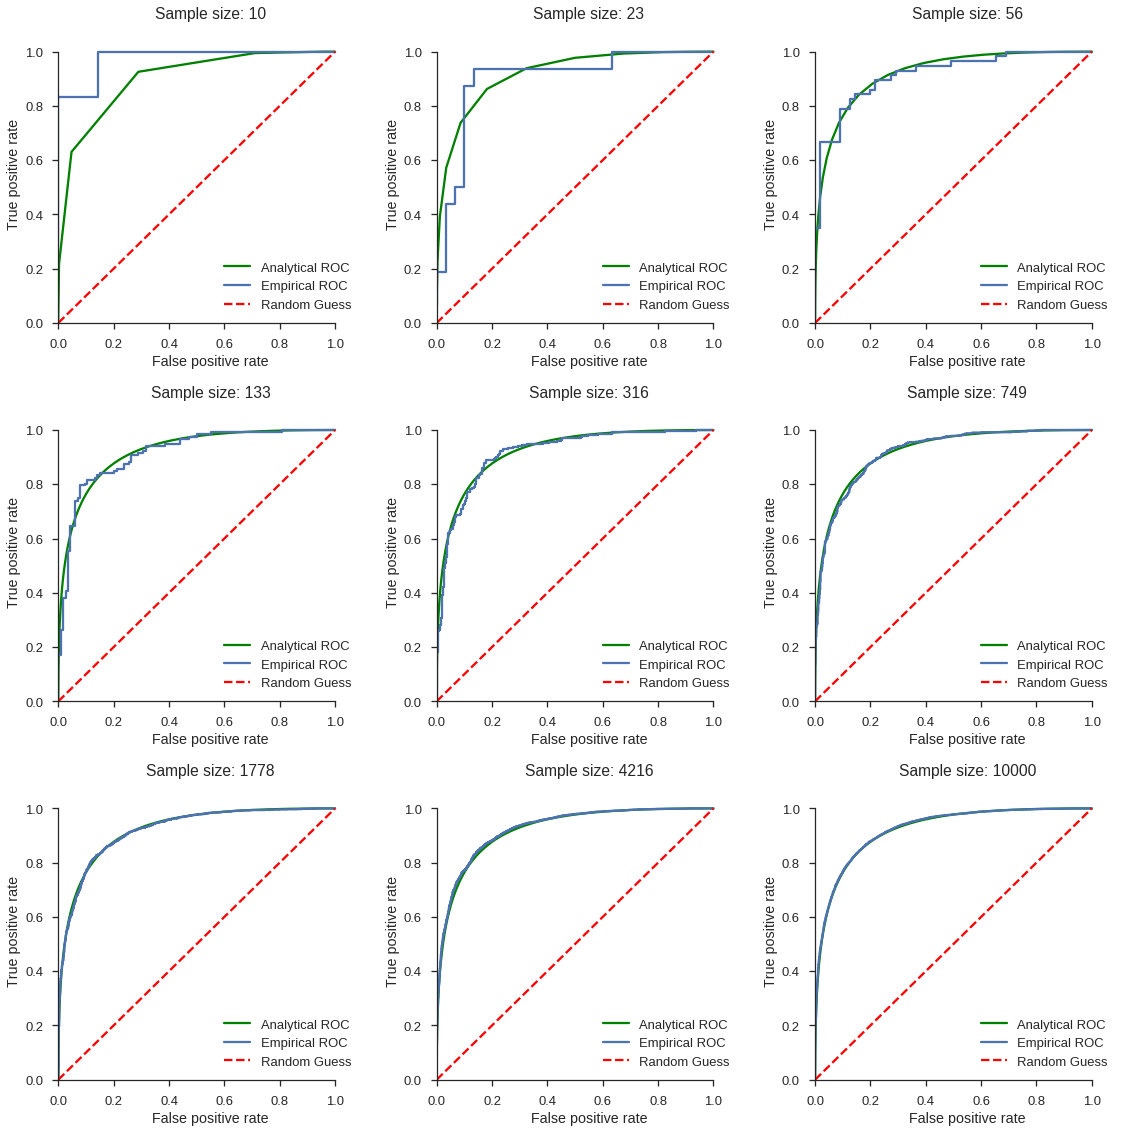

In [6]:
_, axes = plt.subplots(3, 3, figsize=(16, 16))
axes = axes.flat
for s, ax in zip(np.logspace(1, 4, 9), axes):
    plot_roc(s, ax)
plt.tight_layout()

## Assignment 4

Processing dataset: banana
Processing dataset: diabetis
Processing dataset: flare-solar
Processing dataset: image
Processing dataset: ringnorm


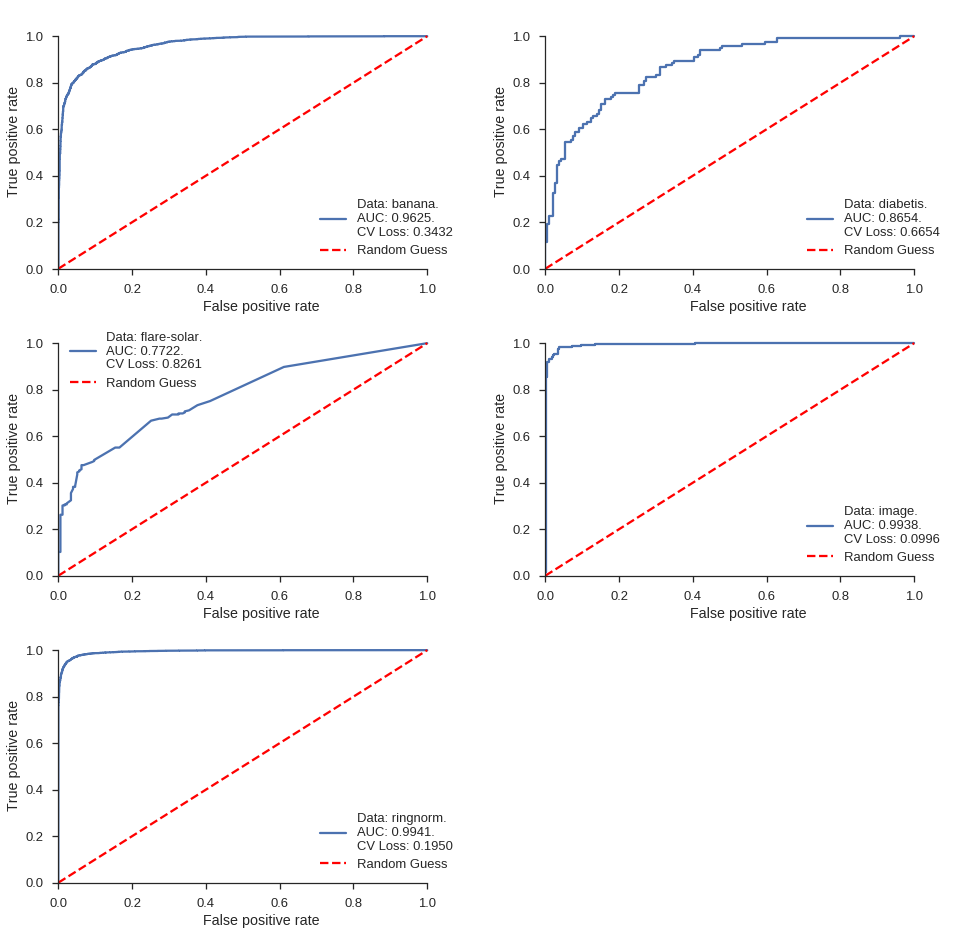

In [7]:
def process_dataset(dataset, ax):
    print(f"Processing dataset: {dataset}")
    X_train = np.loadtxt(f'./sheet3_datasets/U04_{dataset}-xtrain.dat').T
    y_train = np.loadtxt(f'./sheet3_datasets/U04_{dataset}-ytrain.dat').T
    X_test = np.loadtxt(f'./sheet3_datasets/U04_{dataset}-xtest.dat').T
    y_test = np.loadtxt(f'./sheet3_datasets/U04_{dataset}-ytest.dat').T

    kernels = [linear, polynomial, gaussian]
    kp_range = np.linspace(1, 6, 6)

    kernel, kp, c, cvloss = krr_loo_cv(X_train, y_train, kernels, kp_range)
    model = krr(kernel, kp, c)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    auc_val = auc(y_test, y_pred, plot=True, ax=ax)
    cvloss = cvloss.real
    auc_val = auc_val.real
    ax.legend([f"Data: {dataset}.\nAUC: {auc_val:0.4f}.\nCV Loss: {cvloss:0.4f}",
               "Random Guess"])
    return {'kernel': kernel.__name__,
            'kernelparameter': kp,
            'regularization': c,
            'cvloss': cvloss,
            'ypred': y_pred,
            'auc': auc_val}

fig, axes = plt.subplots(3, 2, figsize=(16, 16))
axes = axes.flatten()
datasets = ['banana', 'diabetis', 'flare-solar', 'image', 'ringnorm']
results = {
    dataset: process_dataset(dataset, ax=ax)
    for ax, dataset in zip(axes, datasets)
}
fig.delaxes(axes[-1])

In [8]:
with open('results.p', 'wb') as fp:
    pickle.dump(results, fp)
results

{'banana': {'auc': 0.9624755261251241,
  'cvloss': 0.34324783291189048,
  'kernel': 'gaussian',
  'kernelparameter': 1.0,
  'regularization': 0.010000000000000011,
  'ypred': array([ 1.1115161 , -1.05840192, -1.13072183, ...,  0.13599675,
         -0.68995167, -0.72593865])},
 'diabetis': {'auc': 0.86544991511035652,
  'cvloss': 0.66536734438900524,
  'kernel': 'gaussian',
  'kernelparameter': 6.0,
  'regularization': 1.0000000000000011,
  'ypred': array([-0.10595872, -0.32954365,  0.51886488, -0.32805313, -0.14318874,
         -0.98711814,  0.5404444 , -0.40768213,  0.16381917, -0.84264061,
         -0.02166268, -0.48646483, -0.32344826, -0.5245192 , -1.01508548,
          0.39067638, -0.81622162,  0.5514766 , -1.16412311, -0.31976738,
         -0.40926302, -0.50874808, -0.24275536, -0.7981294 , -0.51959604,
         -0.49497965, -0.62057394,  0.49459197, -0.99168767, -0.39986405,
         -0.84624957, -0.00997375,  0.2539758 ,  0.26258275, -0.58205536,
          0.05587666, -0.292975